# 特徴量作成

In [42]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import os 
import glob
import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# 本人にアノテーションされた性格特性スコアの算出
def calc_persona(filename):
    df = pd.read_excel('../../data/Hazumi1911/questionnaire/1911questionnaires.xlsx', sheet_name=4, index_col=0, header=1)
    data = df.loc[filename, :].values.tolist()
    return [data[0]+(8-data[5]), (8-data[1])+data[6], data[2]+(8-data[7]), data[3]+(8-data[8]), data[4]+(8-data[9])]

# 第三者にアノテーションされた性格特性スコアの算出
def calc_thirdpersona(filename):
    df = pd.read_excel('../../data/Hazumi1911/questionnaire/220818thirdbigfive-Hazumi1911.xlsx', sheet_name=5, header=1, index_col=0)
    data = df.loc[filename].values.tolist()
    return [data[5], data[13], data[21], data[29], data[37]]


### ダンプファイル

In [43]:
audio = {}
text = {}
visual = {} 

third_persona = {}
persona = {}
TS_ternary = {}
SS_ternary = {}
third_sentiment = {}
sentiment = {}

vid = []

path = '../../data/Hazumi1911/dumpfiles/*'

files = glob.glob(path)

for file_path in sorted(files):
    filename = os.path.basename(file_path).split('.', 1)[0]
    df = pd.read_csv(file_path)

    vid.append(filename)
    text[filename] = df.loc[:, 'word#0001':'su'].values.tolist()
    audio[filename] = df.loc[:, 'pcm_RMSenergy_sma_max':'F0_sma_de_kurtosis'].values.tolist()
    visual[filename] = df.loc[:, '17_acceleration_max':'AU45_c_mean'].values.tolist()

    persona[filename] = calc_persona(filename)
    third_persona[filename] = calc_thirdpersona(filename)
    TS_ternary[filename] = df.loc[:, 'TS_ternary'].values.tolist()
    SS_ternary[filename] = df.loc[:, 'SS_ternary'].values.tolist()
    third_sentiment[filename] = df.loc[:, 'TS1':'TS5'].mean(axis='columns').values.tolist()
    sentiment[filename] = df.loc[:, 'SS'].values.tolist()

# ファイル書き込み
with open('../../data/Hazumi_features/Hazumi1911_features.pkl', mode='wb') as f:
    pickle.dump((SS_ternary, TS_ternary, sentiment, third_sentiment, persona, third_persona, text, audio, visual, vid), f)

In [7]:
neg, neu, pos = 0, 0, 0
for value in TS_ternary.values():
    for data in value:
        if data == 0:
            neg += 1
        elif data == 1:
            neu += 1
        else:
            pos += 1
sum = neg + neu + pos
print('-----TS_ternary-----')
print(neg, neu, pos, sum)
majo = max([neg/sum, neu/sum, pos/sum])
print(f'マジョリティベースライン：{majo:.3}')

neg, neu, pos = 0, 0, 0
for value in SS_ternary.values():
    for data in value:
        if data == 0:
            neg += 1
        elif data == 1:
            neu += 1
        else:
            pos += 1
sum = neg + neu + pos
print('-----SS_ternary-----')
print(neg, neu, pos, sum)
majo = max([neg/sum, neu/sum, pos/sum])
print(f'マジョリティベースライン(SS_ternary)：{majo:.3}')

-----TS_ternary-----
178 881 1380 2439
マジョリティベースライン：0.566
-----SS_ternary-----
485 848 1106 2439
マジョリティベースライン(SS_ternary)：0.453


In [38]:
import torch.nn as nn
import torch 

loss_function = nn.MSELoss()

loss_personas = []

a = []
b = []
c = []
d = []
e = []

for id, X in third_persona.items():
    a.append(X[0])
    b.append(X[1])
    c.append(X[2])
    d.append(X[3])
    e.append(X[4])

mean = []
mean.append(np.array(a).mean())
mean.append(np.array(b).mean())
mean.append(np.array(c).mean())
mean.append(np.array(d).mean())
mean.append(np.array(e).mean())

mean = torch.FloatTensor(mean)

for id, X in third_persona.items():
    X = torch.FloatTensor(X)
    loss_personas.append(loss_function(mean, X))

print(np.array(loss_personas).mean())

loss_function2 = nn.CrossEntropyLoss()
loss_sentiment = []

for id, X in TS_ternary.items():
    pred = []
    for x in X:
        pred.append([0.0, 0.0, 1.0])
    pred = torch.FloatTensor(pred)
    X = torch.LongTensor(X)
    loss_sentiment.append((loss_function2(pred, X)))

print(np.array(loss_sentiment).mean())
    

2.052284
0.98032504


/tmp/ipykernel_471389/843685407.py:44: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  X = torch.LongTensor(X)


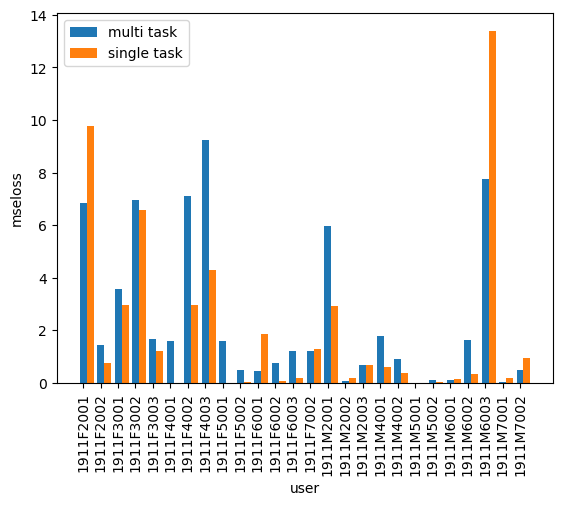

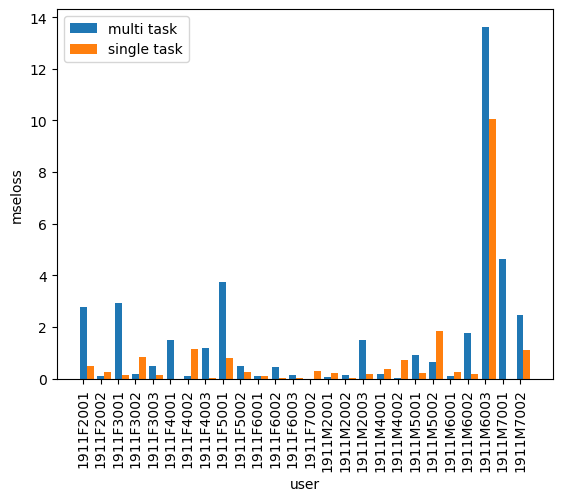

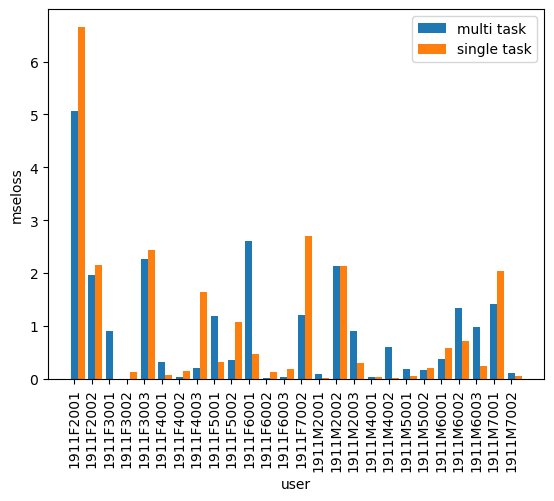

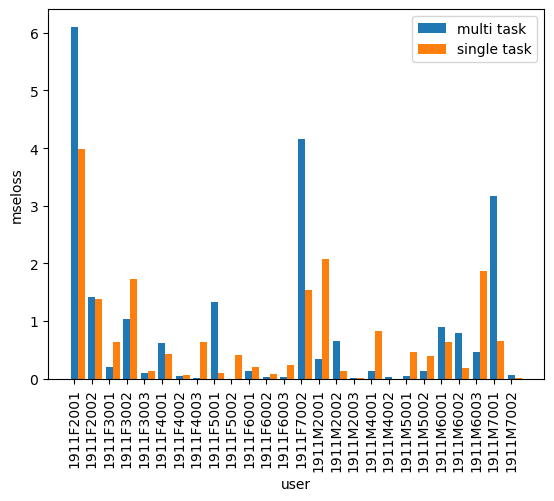

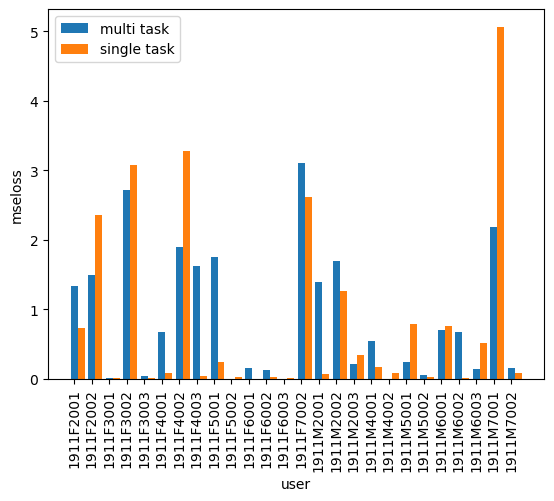

In [96]:
multi_task = [[6.848999977111816, 2.7920000553131104, 5.058000087738037, 6.105999946594238, 1.3420000076293945], [1.4179999828338623, 0.11299999803304672, 1.9539999961853027, 1.4149999618530273, 1.4989999532699585], [3.555999994277954, 2.9179999828338623, 0.9110000133514404, 0.20000000298023224, 0.004000000189989805], [6.952000141143799, 0.17499999701976776, 0.0, 1.0360000133514404, 2.7219998836517334], [1.6679999828338623, 0.503000020980835, 2.2690000534057617, 0.10300000011920929, 0.035999998450279236], [1.5809999704360962, 1.5019999742507935, 0.30799999833106995, 0.6230000257492065, 0.6779999732971191], [7.119999885559082, 0.10499999672174454, 0.032999999821186066, 0.04699999839067459, 1.8990000486373901], [9.234999656677246, 1.1970000267028809, 0.20900000631809235, 0.017999999225139618, 1.6200000047683716], [1.5720000267028809, 3.73799991607666, 1.1920000314712524, 1.3380000591278076, 1.7549999952316284], [0.492000013589859, 0.47999998927116394, 0.3449999988079071, 0.003000000026077032, 0.003000000026077032], [0.4309999942779541, 0.09099999815225601, 2.6050000190734863, 0.13300000131130219, 0.15299999713897705], [0.7649999856948853, 0.46399998664855957, 0.013000000268220901, 0.027000000700354576, 0.12800000607967377], [1.2120000123977661, 0.12800000607967377, 0.039000000804662704, 0.032999999821186066, 0.0020000000949949026], [1.2120000123977661, 0.004999999888241291, 1.1970000267028809, 4.1539998054504395, 3.1110000610351562], [5.960999965667725, 0.06800000369548798, 0.08900000154972076, 0.34200000762939453, 1.3940000534057617], [0.06199999898672104, 0.1599999964237213, 2.1410000324249268, 0.6620000004768372, 1.7020000219345093], [0.6589999794960022, 1.4930000305175781, 0.9120000004768372, 0.017000000923871994, 0.20800000429153442], [1.7669999599456787, 0.17399999499320984, 0.026000000536441803, 0.12600000202655792, 0.5400000214576721], [0.9190000295639038, 0.035999998450279236, 0.593999981880188, 0.03099999949336052, 0.0], [0.0020000000949949026, 0.9350000023841858, 0.1899999976158142, 0.04899999871850014, 0.24300000071525574], [0.09000000357627869, 0.6510000228881836, 0.1679999977350235, 0.13300000131130219, 0.05999999865889549], [0.08699999749660492, 0.10499999672174454, 0.3700000047683716, 0.8920000195503235, 0.6970000267028809], [1.6299999952316284, 1.7730000019073486, 1.340000033378601, 0.7950000166893005, 0.6700000166893005], [7.747000217437744, 13.628999710083008, 0.9850000143051147, 0.47099998593330383, 0.13300000131130219], [0.026000000536441803, 4.645999908447266, 1.4149999618530273, 3.1760001182556152, 2.190000057220459], [0.49300000071525574, 2.4570000171661377, 0.10400000214576721, 0.061000000685453415, 0.15199999511241913]]


single_task = [[9.77400016784668, 0.4779999852180481, 6.659999847412109, 3.986999988555908, 0.7319999933242798], [0.7590000033378601, 0.2409999966621399, 2.1589999198913574, 1.3849999904632568, 2.3519999980926514], [2.9519999027252197, 0.12700000405311584, 0.0, 0.6420000195503235, 0.00800000037997961], [6.559999942779541, 0.8460000157356262, 0.13199999928474426, 1.7339999675750732, 3.072999954223633], [1.222000002861023, 0.13699999451637268, 2.427999973297119, 0.1289999932050705, 0.014000000432133675], [0.0, 0.004999999888241291, 0.06199999898672104, 0.4230000078678131, 0.07599999755620956], [2.953000068664551, 1.1579999923706055, 0.14900000393390656, 0.05900000035762787, 3.2730000019073486], [4.296000003814697, 0.023000000044703484, 1.6380000114440918, 0.6330000162124634, 0.039000000804662704], [0.004999999888241291, 0.7940000295639038, 0.31700000166893005, 0.0949999988079071, 0.2409999966621399], [0.04500000178813934, 0.27000001072883606, 1.0809999704360962, 0.41999998688697815, 0.02800000086426735], [1.8669999837875366, 0.11599999666213989, 0.460999995470047, 0.19900000095367432, 0.0020000000949949026], [0.0729999989271164, 0.03500000014901161, 0.12700000405311584, 0.08900000154972076, 0.026000000536441803], [0.1809999942779541, 0.010999999940395355, 0.17599999904632568, 0.24300000071525574, 0.014000000432133675], [1.2799999713897705, 0.29600000381469727, 2.700000047683716, 1.5429999828338623, 2.614000082015991], [2.9130001068115234, 0.2329999953508377, 0.009999999776482582, 2.0739998817443848, 0.06199999898672104], [0.1850000023841858, 0.019999999552965164, 2.135999917984009, 0.14100000262260437, 1.2610000371932983], [0.6840000152587891, 0.19099999964237213, 0.3050000071525574, 0.017000000923871994, 0.3449999988079071], [0.609000027179718, 0.38199999928474426, 0.04100000113248825, 0.828000009059906, 0.16500000655651093], [0.35100001096725464, 0.7369999885559082, 0.008999999612569809, 0.0010000000474974513, 0.0820000022649765], [0.004000000189989805, 0.23899999260902405, 0.05900000035762787, 0.4560000002384186, 0.7940000295639038], [0.03400000184774399, 1.8420000076293945, 0.1979999989271164, 0.3970000147819519, 0.017999999225139618], [0.15600000321865082, 0.2460000067949295, 0.5789999961853027, 0.6380000114440918, 0.7549999952316284], [0.32899999618530273, 0.17599999904632568, 0.7229999899864197, 0.1860000044107437, 0.010999999940395355], [13.397000312805176, 10.04800033569336, 0.23499999940395355, 1.871999979019165, 0.5199999809265137], [0.1979999989271164, 0.004000000189989805, 2.0409998893737793, 0.6579999923706055, 5.067999839782715], [0.9490000009536743, 1.1139999628067017, 0.05700000002980232, 0.006000000052154064, 0.08900000154972076]]

extr = [[], []]
agre = [[], []]
cons = [[], []]
neur = [[], []]
open = [[], []]

extr_sum = [0, 0]
agre_sum = [0, 0]
cons_sum = [0, 0]
neur_sum = [0 ,0]
open_sum = [0, 0]

for mul, sin in zip(multi_task, single_task):
    extr[0].append(mul[0])
    extr_sum[0] += mul[0]
    extr[1].append(sin[0])
    extr_sum[1] += sin[0]
    agre[0].append(mul[1])
    agre_sum[0] += mul[1]
    agre[1].append(sin[1])
    agre_sum[1] += sin[1]
    cons[0].append(mul[2])
    cons_sum[0] += mul[2]
    cons[1].append(sin[2])
    cons_sum[1] += sin[2]
    neur[0].append(mul[3])
    neur_sum[0] += mul[3]
    neur[1].append(sin[3])
    neur_sum[1] += sin[3]
    open[0].append(mul[4])
    open_sum[0] += mul[4]
    open[1].append(sin[4])
    open_sum[1] += sin[4]


import matplotlib.pyplot as plt 
import numpy as np 

x1 = []
x2 = []
for i, _ in enumerate(vid):
    x1.append(i+1)
    x2.append(x1[i]+0.4)

plt.bar(x1, extr[0], width=0.4, label='multi task')
plt.bar(x2, extr[1], width=0.4, label='single task')
plt.legend()
plt.xticks(x1, vid, rotation=90)
plt.xlabel('user')
plt.ylabel('mseloss')
plt.show()

plt.bar(x1, agre[0], width=0.4, label='multi task')
plt.bar(x2, agre[1], width=0.4, label='single task')
plt.legend()
plt.xticks(x1, vid, rotation=90)
plt.xlabel('user')
plt.ylabel('mseloss')
plt.show()

plt.bar(x1, cons[0], width=0.4, label='multi task')
plt.bar(x2, cons[1], width=0.4, label='single task')
plt.legend()
plt.xticks(x1, vid, rotation=90)
plt.xlabel('user')
plt.ylabel('mseloss')
plt.show()

plt.bar(x1, neur[0], width=0.4, label='multi task')
plt.bar(x2, neur[1], width=0.4, label='single task')
plt.legend()
plt.xticks(x1, vid, rotation=90)
plt.xlabel('user')
plt.ylabel('mseloss')
plt.show()

plt.bar(x1, open[0], width=0.4, label='multi task')
plt.bar(x2, open[1], width=0.4, label='single task')
plt.legend()
plt.xticks(x1, vid, rotation=90)
plt.xlabel('user')
plt.ylabel('mseloss')
plt.show()

In [78]:
print(np.array(extr_sum) / len(vid))
print(np.array(agre_sum) / len(vid))
print(np.array(cons_sum) / len(vid))
print(np.array(neur_sum) / len(vid))
print(np.array(open_sum) / len(vid))

[2.44253845 1.99138464]
[1.55146152 0.76034617]
[0.94103847 0.94165383]
[0.84580769 0.7251923 ]
[0.88234616 0.83315384]


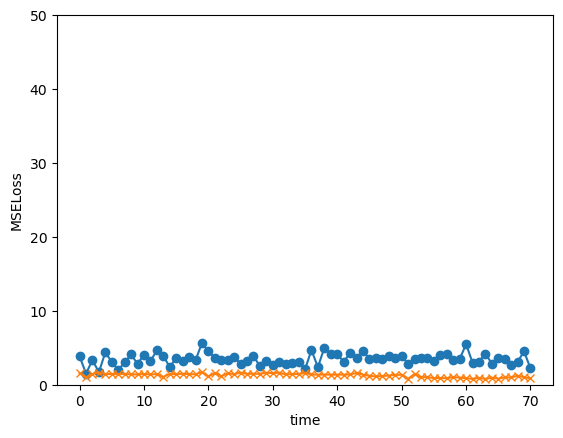

In [95]:
mul = 
sin = 
X = range(0, len(mul))
mul_loss = []
sin_loss = []

for i, x in enumerate(mul):
    mul_loss.append(np.array(x).mean())
    sin_loss.append(np.array(sin[i]).mean())

plt.plot(X, mul_loss, marker = 'o')
plt.plot(X, sin_loss, marker = 'x')

plt.xlabel('time')
plt.ylabel('MSELoss')
plt.ylim(0, 50)
plt.show()